<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 2 Assignment 3*

# Document Classification

Use the following dataset of scraped "Data Scientist" and "Data Analyst" job listings to create your own Document Classification Models.

<https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-2-NLP/master/module3-Document-Classification/job_listings.csv>

Requirements:

- Apply both CountVectorizer and TfidfVectorizer methods to this data and compare results
- Use at least two different classification models to compare differences in model accuracy
- Try to "Hyperparameter Tune" your model by using different n_gram ranges, max_results, and data cleaning methods
- Try and get the highest accuracy possible!

In [128]:
from sklearn import tree, pipeline, metrics, linear_model, model_selection, feature_extraction
from bs4 import BeautifulSoup
import graphviz as gv
import pandas as pd
import numpy as np

In [3]:
url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-2-NLP/master/module3-Document-Classification/job_listings.csv"
jobs = pd.read_csv(url)

In [25]:
jobs["description"] = jobs.description.apply(lambda html: BeautifulSoup((html if type(html) == str else ""), "lxml").text.replace("\\n", " "))

In [65]:
X = jobs.description
y = jobs.job.replace({'Data Scientist': 0, 'Data Analyst': 1})

In [66]:
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: job, dtype: float64

In [67]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [68]:
X_train.shape

(375,)

#### CountVectorizer

In [110]:
vectorizer = feature_extraction.text.CountVectorizer(
    max_features=None, 
    ngram_range=(1,1), 
    stop_words='english'
)

In [111]:
regressor = linear_model.LogisticRegression()

In [112]:
model_selection.cross_validate(
    regressor, 
    vectorizer.fit_transform(X), 
    y, 
    cv=5,
    n_jobs=-1, 
    scoring='f1'
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.07686424, 0.12604189, 0.12622285, 0.12543225, 0.08387494]),
 'score_time': array([0.01220655, 0.00266504, 0.00290632, 0.00231838, 0.00151491]),
 'test_score': array([0.88888889, 0.94845361, 0.86538462, 0.91666667, 0.90196078]),
 'train_score': array([0.99502488, 0.9924812 , 1.        , 0.99749373, 0.9924812 ])}

In [113]:
model_selection.cross_validate(
    regressor, 
    vectorizer.fit_transform(X), 
    y, 
    cv=5, 
    n_jobs=-1, 
    scoring='roc_auc'
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.16477895, 0.14227533, 0.11529899, 0.14661288, 0.05015945]),
 'score_time': array([0.00292706, 0.00316525, 0.02681923, 0.00951338, 0.00140476]),
 'test_score': array([0.9768, 0.9872, 0.9516, 0.9776, 0.966 ]),
 'train_score': array([0.99995  , 0.9998875, 1.       , 0.9999875, 0.9998875])}

#### TfidfVectorizer

In [117]:
vectorizer = feature_extraction.text.TfidfVectorizer(
    max_features=None, 
    ngram_range=(1,1), 
    stop_words='english'
)

In [118]:
regressor = linear_model.LogisticRegression()

In [119]:
model_selection.cross_validate(
    regressor, 
    vectorizer.fit_transform(X), 
    y, 
    cv=5, 
    n_jobs=-1, 
    scoring='f1'
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.04161191, 0.02897596, 0.02064013, 0.04095984, 0.02248669]),
 'score_time': array([0.0024786 , 0.00325036, 0.01603985, 0.0024519 , 0.00117731]),
 'test_score': array([0.89719626, 0.91089109, 0.8411215 , 0.90384615, 0.86538462]),
 'train_score': array([0.96741855, 0.97766749, 0.98      , 0.97256858, 0.97243108])}

In [120]:
model_selection.cross_validate(
    regressor, 
    vectorizer.fit_transform(X), 
    y, 
    cv=5, 
    n_jobs=-1, 
    scoring='roc_auc'
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.02653265, 0.04629421, 0.03290439, 0.0350883 , 0.01840854]),
 'score_time': array([0.0031507 , 0.00238705, 0.01424432, 0.00947928, 0.00135756]),
 'test_score': array([0.9408, 0.9764, 0.9392, 0.9752, 0.944 ]),
 'train_score': array([0.997875 , 0.9983375, 0.999075 , 0.9983375, 0.9985875])}

In [121]:
classifier = tree.DecisionTreeClassifier(max_depth=3)

In [122]:
model_selection.cross_validate(
    classifier, 
    vectorizer.fit_transform(X), 
    y, 
    cv=5, 
    n_jobs=-1, 
    scoring='roc_auc'
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.05574036, 0.05598903, 0.05713224, 0.05582428, 0.03481126]),
 'score_time': array([0.00421906, 0.00397062, 0.00407624, 0.00386405, 0.0022893 ]),
 'test_score': array([0.9352, 0.9328, 0.9166, 0.9634, 0.9502]),
 'train_score': array([0.96795  , 0.9767375, 0.9754375, 0.9714125, 0.9756   ])}

In [124]:
classifier.fit(vectorizer.fit_transform(X), y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [125]:
dots = tree.export_graphviz(
    classifier, 
    out_file=None, 
    feature_names=vectorizer.get_feature_names(), 
    class_names=['Data Scientist', 'Data Analyst'],
    filled=True, 
    impurity=False,
    proportion=True
)

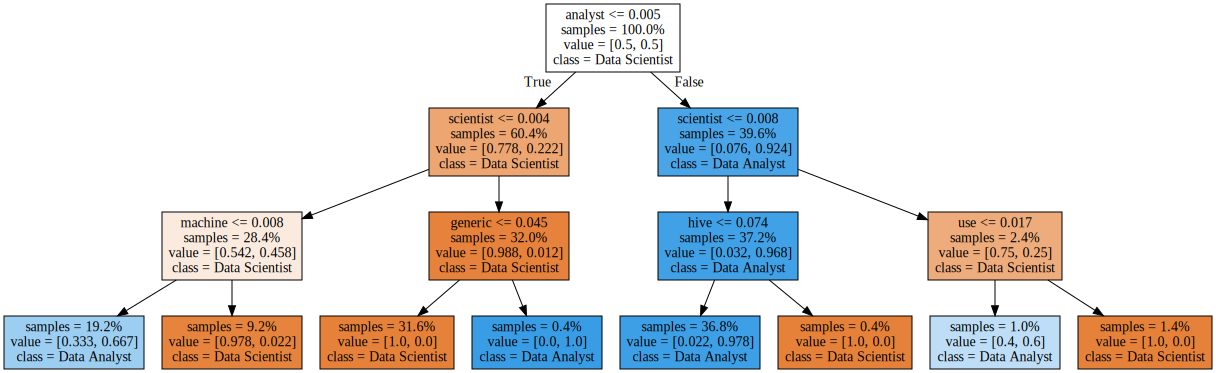

In [129]:
gv.Source(dots)

# Stretch Goals

- Try some agglomerative clustering using cosine-similarity-distance! (works better with high dimensional spaces) robust clustering - Agglomerative clustering like Ward would be cool. Try and create an awesome Dendrogram of the most important terms from the dataset.

- Awesome resource for clustering stretch goals: 
 - Agglomerative Clustering with Scipy: <https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/>
 - Agglomerative Clustering for NLP: <http://brandonrose.org/clustering>
 
- Use Latent Dirichlet Allocation (LDA) to perform topic modeling on the dataset: 
 - Topic Modeling and LDA in Python: <https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24>
 - Topic Modeling and LDA using Gensim: <https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/>
